In [ ]:
! pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[1]") \
                                    .appName('ASL_Recomender') \
                                    .config("spark.driver.memory", "4g") \
                                    .config("spark.executor.memory", "4g") \
                                    .getOrCreate()

In [4]:
spark

In [5]:
df = spark.read.csv("cleaned_data.csv", header=True, multiLine=True, quote='"', escape='"', inferSchema=True)

In [6]:
df.show()

+------+--------------------+--------------------+--------------------+----------+-----------+--------------------+-------------+------------+-----------------+-------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+--------------------+---------------+--------+------+-------------+----+
|rating|             title_x|                text|            images_x|      asin|parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|main_category|             title_y|average_rating|rating_number|            features|         description|price|            images_y|              videos|               store|categories|             details|bought_together|subtitle|author|review_length|year|
+------+--------------------+--------------------+--------------------+----------+-----------+--------------------+-------------+------------+-----------------+--

In [7]:
df = df[['user_id','parent_asin','rating']]
df.show()

+--------------------+-----------+------+
|             user_id|parent_asin|rating|
+--------------------+-----------+------+
|AEYORY2AVPMCPDV57...| B08BBQ29N5|   3.0|
|AFSKPY37N3C43SOI5...| B07KG1TWP5|   5.0|
|AFSKPY37N3C43SOI5...| B07W397QG4|   5.0|
|AHGAOIZVODNHYMNCB...| B077SRDVG9|   3.0|
|AFZUK3MTBIBEDQOPA...| B00946HGLW|   5.0|
|AH4O5W3EM4CKQGHMB...| B07CJWG8SP|   5.0|
|AFPBVAEV3FCQOHKJJ...| B01HO1ZB7Y|   5.0|
|AHV6QCNBJNSGLATP5...| B0B4JPGX8P|   4.0|
|AHV6QCNBJNSGLATP5...| B083TLNBJJ|   4.0|
|AHV6QCNBJNSGLATP5...| B084D86YL8|   3.0|
|AHV6QCNBJNSGLATP5...| B07SW7D6ZR|   4.0|
|AHV6QCNBJNSGLATP5...| B07NPWK167|   5.0|
|AHV6QCNBJNSGLATP5...| B07KV31WDS|   5.0|
|AEVLPO2NHUQOLLCLF...| B08JLXLJGS|   4.0|
|AGPOZ62Q3ULTH7RLB...| B003USID1C|   5.0|
|AFJBKPK5W56XWSNPQ...| B09JZXY4YR|   5.0|
|AFJBKPK5W56XWSNPQ...| B08SQ31H8P|   4.0|
|AFJBKPK5W56XWSNPQ...| B08LYT4Q2X|   5.0|
|AFJBKPK5W56XWSNPQ...| B087ZQK2G8|   4.0|
|AFTWZJUP2224KGWPB...| B07NGCSZYY|   5.0|
+--------------------+-----------+

In [ ]:
from pyspark.sql.functions import col, count
df_columns = df.select("user_id","parent_asin","rating") \
                        .withColumnRenamed("parent_asin","product_id")

user_review_counts = df_columns.groupBy("user_id") \
                               .agg(count("*").alias("review_count"))


active_users = user_review_counts.filter(col("review_count") >= 5) \
                                 .select("user_id")

final_df = df_columns.join(active_users,on="user_id",how="inner")

final_df.show()

+--------------------+----------+------+
|             user_id|product_id|rating|
+--------------------+----------+------+
|AEYORY2AVPMCPDV57...|B08BBQ29N5|   3.0|
|AFSKPY37N3C43SOI5...|B07KG1TWP5|   5.0|
|AFSKPY37N3C43SOI5...|B07W397QG4|   5.0|
|AHGAOIZVODNHYMNCB...|B077SRDVG9|   3.0|
|AFZUK3MTBIBEDQOPA...|B00946HGLW|   5.0|
|AH4O5W3EM4CKQGHMB...|B07CJWG8SP|   5.0|
|AHV6QCNBJNSGLATP5...|B0B4JPGX8P|   4.0|
|AHV6QCNBJNSGLATP5...|B083TLNBJJ|   4.0|
|AHV6QCNBJNSGLATP5...|B084D86YL8|   3.0|
|AHV6QCNBJNSGLATP5...|B07SW7D6ZR|   4.0|
|AHV6QCNBJNSGLATP5...|B07NPWK167|   5.0|
|AHV6QCNBJNSGLATP5...|B07KV31WDS|   5.0|
|AFJBKPK5W56XWSNPQ...|B09JZXY4YR|   5.0|
|AFJBKPK5W56XWSNPQ...|B08SQ31H8P|   4.0|
|AFJBKPK5W56XWSNPQ...|B08LYT4Q2X|   5.0|
|AFJBKPK5W56XWSNPQ...|B087ZQK2G8|   4.0|
|AFXF3EGQTQDXMRLDW...|B0B8F6MWFJ|   3.0|
|AFXF3EGQTQDXMRLDW...|B0B5X48DZR|   3.0|
|AFXF3EGQTQDXMRLDW...|B09GNXK3N1|   4.0|
|AFXF3EGQTQDXMRLDW...|B08HX5J4P5|   3.0|
+--------------------+----------+------+
only showing top

In [9]:
from pyspark.ml.feature import StringIndexer
# Convert user_id to numeric
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_index")

# Fit and transform
indexed_df = user_indexer.fit(final_df).transform(final_df)
indexed_df = product_indexer.fit(indexed_df).transform(indexed_df)

In [10]:


from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit,ParamGridBuilder


(training,test) = indexed_df.randomSplit([0.8,0.2])

als = ALS(userCol="user_index",itemCol="product_index",ratingCol="rating",coldStartStrategy="drop",nonnegative = True)

param_grid = ParamGridBuilder() \
              .addGrid(als.rank,[12,13,14])\
              .addGrid(als.maxIter,[18,19,20])\
              .addGrid(als.regParam,[.17,.18,.19])\
              .build()

evaluator = RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator)

model = tvs.fit(training)

best_model = model.bestModel

predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)


In [11]:
print("RMSE = " + str(rmse))

RMSE = 1.313275630830225


In [12]:
display(predictions.sort("user_index","rating"))

DataFrame[user_id: string, product_id: string, rating: double, user_index: double, product_index: double, prediction: float]

In [13]:
user_recs = best_model.recommendForAllUsers(5)
user_recs.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                |
+----------+-----------------------------------------------------------------------------------------------+
|0         |[{4821, 5.4103684}, {1233, 5.3106112}, {791, 5.130827}, {3209, 4.915303}, {948, 4.915303}]     |
|1         |[{189, 4.764987}, {5710, 4.7582965}, {5508, 4.7582965}, {5319, 4.7582965}, {5099, 4.7582965}]  |
|2         |[{1233, 5.1347094}, {608, 5.093201}, {1488, 4.933686}, {3665, 4.9015045}, {2918, 4.9015045}]   |
|3         |[{1233, 5.435513}, {1040, 5.205432}, {3906, 5.142887}, {608, 5.117509}, {4821, 5.091583}]      |
|4         |[{1233, 5.41597}, {608, 5.2233553}, {1489, 5.0835114}, {4821, 5.0694957}, {1810, 5.067991}]    |
|5         |[{1233, 5.6531196}, {2780, 5.177629}, {4821, 5.1765957}, {736, 5.1570354}, {608, 5.154582}]    |
|6         |[{1233,

In [ ]:
! pip install matplotlib

In [15]:

from pyspark.sql import functions as F 

import matplotlib.pyplot as plt

# Step 1: Get 3 random users from the test set
sample_users_df = test.select("user_index").distinct().orderBy(F.rand()).limit(3)

# Step 2: Get top 5 recommendations for these users
sample_user_recs = best_model.recommendForUserSubset(sample_users_df, 5)

# Step 3: Explode the recs
exploded_sample = sample_user_recs.selectExpr("user_index", "explode(recommendations) as rec") \
                                  .select("user_index", F.col("rec.product_index"), F.col("rec.rating"))

user_id_mapping = indexed_df.select("user_id", "user_index").distinct()
product_id_mapping = indexed_df.select("product_id", "product_index").distinct()

# Step 4: Map back to original user_id and product_id
sample_pretty_recs = exploded_sample \
    .join(user_id_mapping, on="user_index") \
    .join(product_id_mapping, on="product_index") \
    .select("user_id", "product_id", "rating") \
    .orderBy("user_id", F.col("rating").desc())




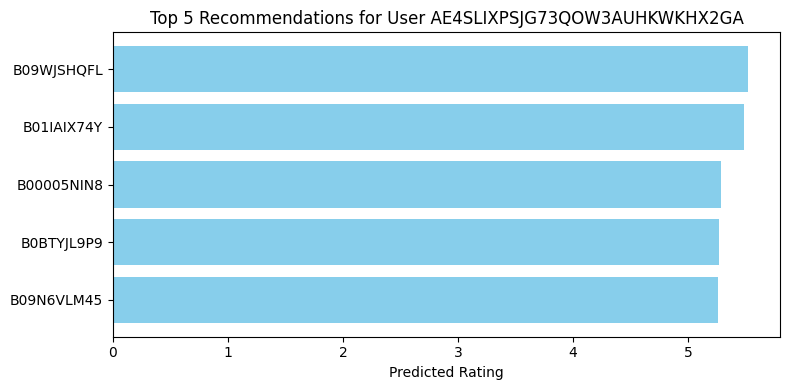

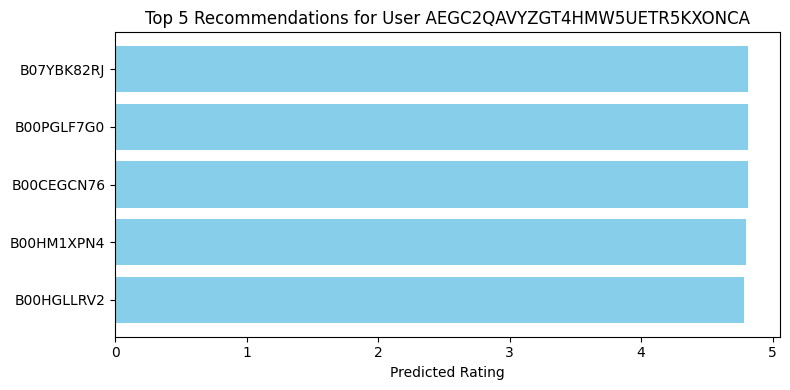

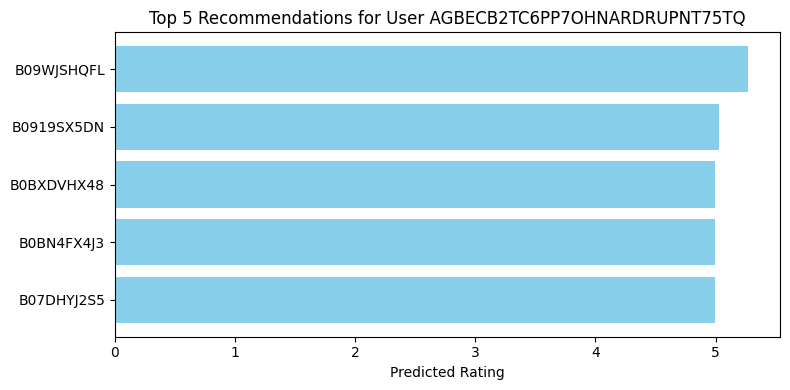

In [16]:
# Convert to Pandas for easier plotting
sample_pdf = sample_pretty_recs.toPandas()

# Plot top 5 recommendations for each user
for user in sample_pdf["user_id"].unique():
    user_data = sample_pdf[sample_pdf["user_id"] == user]
    
    plt.figure(figsize=(8, 4))
    plt.barh(user_data["product_id"], user_data["rating"], color="skyblue")
    plt.xlabel("Predicted Rating")
    plt.title(f"Top 5 Recommendations for User {user}")
    plt.gca().invert_yaxis()  # Invert to have highest ratings on top
    plt.tight_layout()
    plt.show()